## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2022.

# Assignment 2 - Task 2: Regularizations

In this task, you are going to experiment with two popular regularization methods. 

**Batch normalization:** Batch normalization makes it possible to train a deep network. When a network becomes deeper, the distribution of hidden neurons' values will also shift greatly, and that is one reason that makes it difficult to train a deep neural network. Machine learning taught us that normalization is a good preprocessing method to deal with such a problem. Therefore, batch normalization deploys a similar idea in neural networks by re-normalizing the hidden values of each layer before transfering values to the next layer.

**Dropout:** In the last assignment, you trained a shallow network and everything looked fine. However, when the network becomes larger and deeper, it will also become harder to train. The first potential problem is overfitting, that is, the network overreacts to noise or random errors of the training data while failing to detect the underlying distribution pattern. It is more likely to occur when the model becomes complex and contains more trainable parameters. Dropout is a well-known method that can eliminate such effects. The core idea behind it is quite simple: rather than updating all trainable parameters each time, it randomly selects a subset of parameters to update and keeps other parameters unaltered.

* References
    * https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf
    * https://arxiv.org/pdf/1502.03167.pdf
    * https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
    * https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization

In [15]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [16]:
# Load the raw Fashion-MNIST data.
train, val = fashion_mnist.load_data()

X_train_raw, y_train = train
X_val_raw, y_val = val

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_val = X_val_raw.reshape((X_val_raw.shape[0], X_val_raw.shape[1]**2))

#Index from the 10000th image of the dataset
# X_val = X_train[10000:10500,:]
# y_val = y_train[10000:10500]
# X_train = X_train[10500:12500,:]
# y_train = y_train[10500:12500]

mean_image = np.mean(X_train, axis=0).astype(np.float32)
X_train = X_train.astype(np.float32) - mean_image
X_val = X_val.astype(np.float32) - mean_image

# We've vectorized the data for you. That is, we flatten the 32×32×3 images into 1×3072 Numpy arrays.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)

Training data shape:  (60000, 784)
Training labels shape:  (60000,)
Validation data shape:  (10000, 784)
Validation labels shape:  (10000,)


## Part 1: Batch Normalization

### Implement batch normalization forward function

For some batched input data $X_b = (x_1, \dots, x_N)^T \in R^{N \times D}$, $x_i \in R^D$, $N$ is the batch size, $b = 1 \dots B$ is the batch index (e.g. $X_1$ denotes the 1st batch), $B$ is the total number of batches and $D$ is the dimension of the data. 

To do a batch normalization, first we estimat the normalized value of the inputs

$$
\hat{X}_b = \frac{X_b - \mu_b}{\sqrt{\sigma_b^2 + \epsilon}} \in R^{N \times D} \quad 
\text{where} \quad
\begin{cases}
\mu_b = \alpha \mu_{b-1} + (1 - \alpha) \bar{X}_b \\
\sigma_b^2 = \alpha \sigma_{b-1} + (1 - \alpha) S^2(X_b) \\
\end{cases}
$$

where 

$$
\bar{X}_b = \frac{1}{N} \sum_{i=1}^N x_i \in R^D, \quad
S^2(X_b) = \frac{1}{N} \sum_{i=1}^N (x_i - \bar{X}_b)^2 \in R^D
$$

Here, $\alpha$ is the decay factor, $\mu_b$ and $\sigma_b^2$ are the ***moving mean*** and ***moving variance*** for batch $b$. They are defined by an exponentially decaying sum of the mean / variance from all previous batches (from $1$ to $b - 1$) and the actual sample mean / variance of the current batch. 

Both $\mu_0$ and $\sigma_0^2$ are initialized to be $\mathbb{0}$. 

Note that considering the simplicity of expressions, we are actually abusing the shapes of the variables. For the term $X_b - \mu_b$, in reality we have $X_b \in R^{N \times D}$ and $\mu_b \in R^D$. As a result, when doing $X_b - \mu_b$ we are actually subtracting $\mu_b$ from every one of the N rows from $X_b$ (i.e. the formula should be $X_b - \mathbb{1} \mu_b^T$), likewise for the $\sigma_b^2 \in R^D$ in the denominator. Of course, when you're writing codes, the [broadcasting mechanism](https://numpy.org/doc/stable/user/basics.broadcasting.html) in numpy will automatically do this for you. See the details in the **./utils/reg_funcs.py**. 

Also note that $S^2$ here denotes the **variance**, however in the field machine learning (and statistics) it more commonly stands for **sample variance** which is something that's slightly different. 

Then the batch normalization is computed as

$$
Y_b = \hat{X}_b \odot \gamma + \beta
$$

where $\beta, \gamma \in R^D$ are **learnable parameters** corresponding to the normalized mean and standard deviation. 

<span style="color:red"><strong>TODO:</strong></span> Edit functions `bn_forward` in **./utils/reg_funcs.py**

If the code is running correctly, **mean of a2_bn for train will be very close to 0 and variance of a2_bn will be close to 1.**

In [3]:
####################################################
# Checking/verification code. Don't change it.     #
####################################################

from utils.reg_funcs import bn_forward
from utils.reg_funcs import bn_backward

np.random.seed(2022)
N, D, H1, H2 = 200, 64, 3, 3
eps = 1e-5
x_in = np.random.randn(N, D)
w1 = np.random.randn(D,H1)
w2 = np.random.randn(H1,H2)
a2 = np.maximum(x_in.dot(w1),0).dot(w2)

# Before batch normalization
print("mean of a2: ", np.mean(a2, axis=0))
print("var of a2: ", np.var(a2, axis=0))

# Test "train mode" of forward function
# After batch normalization, the mean should be close to zero and var should be close to one. 
bn_config = {"epsilon":eps, "decay":0.9}
gamma = np.ones(H2)
beta = np.zeros(H2)
a2_bn, _ = bn_forward(a2, gamma, beta, bn_config, "train")
print("(train) mean of a2_bn:", np.mean(a2_bn, axis=0))
print("(train) var of a2_bn:", np.var(a2_bn, axis=0))
print('*'*80)
print("Is mean correct? -", np.allclose(np.mean(a2_bn, axis=0), np.zeros_like(np.mean(a2_bn, axis=0))))
print("Is variance correct? -", np.allclose(np.var(a2_bn, axis=0), np.ones_like(np.var(a2_bn, axis=0))))

mean of a2:  [-5.54895299  6.93351234 -9.51414004]
var of a2:  [ 71.27582738  38.28448262 155.67504973]
(train) mean of a2_bn: [-1.24379673e-16 -7.37743200e-16 -1.04777298e-17]
(train) var of a2_bn: [0.99999986 0.99999974 0.99999994]
********************************************************************************
Is mean correct? - True
Is variance correct? - True


<span style="color:red"><strong>TODO:</strong></span> Test "moving average" and "test mode" of the `bn_forward` function. 

We expect that the test mean & variance of a2 to be fairly close to the real values and the test mean & variance of a2_bn to be close to 0 and 1 respectively. 

In [4]:
#######################################
# Checking code. Don't change it.     #
#######################################

# Test "moving average" and "test mode" of forward function
# Then you are going to run the forward function under "training mode" for several times, 
# and the moving mean and moving var will be close to the real mean and var of the input data.
# Next, run the forward function under "test" mode and you will see that the mean and var of its 
# output will be also close to gamma, beta that you have set before.

bn_config = {"epsilon":1e-8, "decay":0.8}
gamma = np.ones(H2)
beta = np.zeros(H2)

# collect_data: for calculating real mean and var of a2 later.
collect_data = a2
np.random.seed(2022)
for _ in range(100):
    x_in = np.random.randn(N, D)
    a2 = np.maximum(x_in.dot(w1),0).dot(w2)
    collect_data = np.concatenate((collect_data, a2), axis=0)
    bn_forward(a2, gamma, beta, bn_config, "train")

# compare moving_mean and moving_var with real mean and var.
# You should see that they are close to each other.
print("real mean of data: ", np.mean(collect_data, axis=0))
print("real var of data: ", np.var(collect_data, axis=0))
print("moving mean of data: ", bn_config["moving_mean"])
print("moving var of data: ", bn_config["moving_var"])

# "test mode" of forward function
# After bn_forward, the mean and var of output should be kind of close to gamma and beta.
x_in = np.random.randn(N, D)
a2 = np.maximum(x_in.dot(w1),0).dot(w2)
print("*"*80)
print("(test) mean of a2: ", np.mean(a2, axis=0))
print("(test) var of a2: ", np.var(a2, axis=0))
a2_bn, _ = bn_forward(a2, gamma, beta, bn_config, "test")
print("(test) mean of a2_bn: ", np.mean(a2_bn, axis=0))
print("(test) var of a2_bn: ", np.var(a2_bn, axis=0))
print("*"*80)
print("Is moving mean correct? -", np.allclose(bn_config["moving_mean"], np.mean(collect_data, axis=0), rtol=1e-1))
print("Is moving variance correct? -", np.allclose(bn_config["moving_var"], np.var(collect_data, axis=0), rtol=1e-1))
print("Is test mean correct? -", np.allclose(np.mean(a2_bn, axis=0), beta, atol=2e-1))
print("Is test variance correct? -", np.allclose(np.var(a2_bn, axis=0), gamma, atol=2e-1))

real mean of data:  [-5.37220827  6.60338545 -9.18536976]
real var of data:  [ 69.59934038  36.79350132 154.92350758]
moving mean of data:  [-5.20455938  6.62394822 -8.95234272]
moving var of data:  [ 71.56319735  37.18466888 160.30635746]
********************************************************************************
(test) mean of a2:  [-5.6898722   6.74882481 -9.67056048]
(test) var of a2:  [ 71.95880679  31.8456604  156.68851536]
(test) mean of a2_bn:  [-0.05736895  0.02047854 -0.05672582]
(test) var of a2_bn:  [1.00552811 0.85641909 0.9774317 ]
********************************************************************************
Is moving mean correct? - True
Is moving variance correct? - True
Is test mean correct? - True
Is test variance correct? - True


### Batch normalization backward function

To do a back propogation, just simply take the derivitives. Assume that the upstream gradient from the final output $Z$ w.r.t the layer output $Y$ is $\nabla_Y Z = g \in R^{N \times D}$, the backward pass is

$$
\nabla_{X} Z = \frac{1}{\sqrt{\sigma^2+\epsilon}} \odot \gamma \odot g \in R^{N \times D}, \quad 
\nabla_{\gamma} Z = \mathbb{1}^T (g \odot \frac{X - \mu}{\sqrt{\sigma^2 + \epsilon}}) \in R^D, \quad
\nabla_{\beta} Z = \mathbb{1}^T g \in R^D
$$

Here we use $\mu = \mu_B$ and $\sigma = \sigma_B$ (the final moving mean / variance we cached after the last batch of input in the forward stage). 

<span style="color:red"><strong>TODO:</strong></span> Use TensorFlow 2 functions to verify the correctness of the backward function. 

<span style="color:red"><strong>Hint:</strong></span> Use `tf.GradientTape()`. You may find an example usage in the instructor's verification code from Assignment 1 Task1. 

In [5]:
# After verifying the forward function and save the bn_config.
x_in = np.random.randn(N, D)
a2 = np.maximum(x_in.dot(w1),0).dot(w2)
da2_bn = np.ones_like(a2)
# Test backward function with tensorflow
# You will use bn_config = {"eps":1e-5, "decay":0.9, "moving_mean":moving_mean, "moving_var":moving_var}
gamma = np.ones(H2)
beta = np.zeros(H2)
a2_bn, cache = bn_forward(a2, gamma, beta, bn_config, "test")
da2, dgamma, dbeta = bn_backward(da2_bn, cache)

# results
da2_tf = tf.zeros_like(da2)
dgamma_tf = tf.zeros_like(dgamma)
dbeta_tf = tf.zeros_like(dbeta)

###################################################
# TODO: verify the backward code. You should use  #
# the parameters in bn_config and other variables #
# above.                                          #
# You should store:                               #
#     - da2_tf: gradient of a2_bn w.r.t a2        #
#     - dgamma_tf: gradient of a2_bn w.r.t gamma  #
#     - dbeta_tf: gradient of a2_bn w.r.t beta    #
###################################################
# raise NotImplementedError
a2_tf    = tf.Variable(a2)
gamma_tf = tf.Variable(gamma)
beta_tf  = tf.Variable(beta)


with tf.GradientTape() as tape:
    a2_bn_check = tf.nn.batch_normalization(a2_tf, bn_config["moving_mean"], 
                                         bn_config["moving_var"], beta_tf, 
                                         gamma_tf, bn_config["epsilon"])
    da2_check, dgamma_check, dbeta_check = tape.gradient(a2_bn_check, (a2_tf, gamma_tf, beta_tf))

###################################################
# ENDTODO #
###################################################
    
# Make comparison
print("Is a2_bn correct? {}".format(np.allclose(a2_bn, a2_bn_check)))
print("Is da2 correct? {}".format(np.allclose(da2, da2_check)))
print("Is dgamma correct? {}".format(np.allclose(dgamma, dgamma_check)))
print("Is dbeta correct? {}".format(np.allclose(dbeta, dbeta_check)))

Is a2_bn correct? True
Is da2 correct? True
Is dgamma correct? True
Is dbeta correct? True


### Batch Normalization Experiments with MLP

<span style="color:red"><strong>TODO:</strong></span>

1. Add batch normalization into MLP in `./utils/neuralnets/mlp.py`

2. First create a shallow MLP like two-layer network with shape [50(+10)] (a hidden layer with depth 5 and an output layer of 10 classes). Train it without and with batch normalization. Plot the loss, training accuracy, and validation accuracy curves.

3. Then, create a slightly deeper 3-layer MLP network with shape [50,20(+10)] and train the network with and without batch normalization. Plot the loss, training accuracy, and validation accuracy curves.

4. Make a comparison and describe what you have found in this experiment.

**Experiment on shallow MLP** 

Here in the demo, we set a large learning rate on purpose. You can play with different learning rates and see what happens. 

In [7]:
from utils.neuralnets.mlp import MLP 
from utils.optimizers import AdamOptim

In [8]:
# Build a two-layer network without batch normalization.
# Here is a demo.
use_bn = False
model = MLP(input_dim=X_train.shape[1], hidden_dims=[50], num_classes=10, 
            weight_scale=1e-3, l2_reg=0.0, use_bn=use_bn)
optimizer = AdamOptim(model)
# hist_no_dropout contains loss, train acc and valid acc history.
hist_shallow_no_bn = optimizer.train(model, X_train, y_train, X_val, y_val, 
                           num_epoch=5, batch_size=100, learning_rate=2e-2, learning_decay=0.95, 
                           verbose=False, record_interval = 4)

number of batches for training: 600
epoch 1: valid acc = 0.7567, new learning rate = 0.019
epoch 2: valid acc = 0.7847, new learning rate = 0.01805
epoch 3: valid acc = 0.7636, new learning rate = 0.0171475
epoch 4: valid acc = 0.7841, new learning rate = 0.016290125
epoch 5: valid acc = 0.7831, new learning rate = 0.015475618749999998


In [9]:
# Build a two-layer network with batch normalization. Remember to "use_bn".
use_bn = True
model = MLP(input_dim=X_train.shape[1], hidden_dims=[50], num_classes=10, 
            weight_scale=1e-3, l2_reg=0.0, use_bn=use_bn)
optimizer = AdamOptim(model)
# hist_no_dropout contains loss, train acc and valid acc history.
hist_shallow_bn = optimizer.train(model, X_train, y_train, X_val, y_val, 
                           num_epoch=5, batch_size=100, learning_rate=2e-2, learning_decay=0.95, 
                           verbose=False, record_interval = 4)

number of batches for training: 600
epoch 1: valid acc = 0.8387, new learning rate = 0.019
epoch 2: valid acc = 0.8538, new learning rate = 0.01805
epoch 3: valid acc = 0.8616, new learning rate = 0.0171475
epoch 4: valid acc = 0.8662, new learning rate = 0.016290125
epoch 5: valid acc = 0.8705, new learning rate = 0.015475618749999998


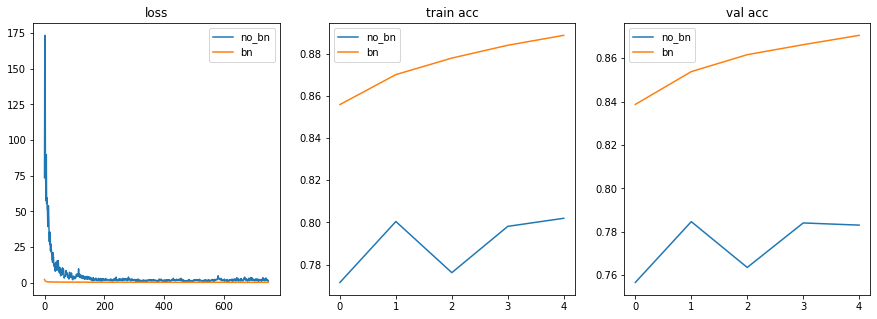

In [10]:
# Plot bn and no_bn results together in three plots and make a comparison. 
title_name = ["loss", "train acc", "val acc"]
_, axarr = plt.subplots(1,3, figsize=(15,5))
for i in range(3):
    axarr[i].plot(hist_shallow_no_bn[i], label="no_bn")
    axarr[i].plot(hist_shallow_bn[i], label="bn")
    axarr[i].legend(), axarr[i].set_title(title_name[i])
plt.show()

**Experiment on deep MLP** 

Here in the demo, we set a large learning rate on purpose. You can play with different learning rates and see what happens. 

In [11]:
# Build a deep 5-layer network without batch normalization. Remember to "use_bn".
use_bn = False
model = MLP(input_dim=X_train.shape[1], hidden_dims=[100, 50], num_classes=10, 
            weight_scale=1e-3, l2_reg=0.0, use_bn=use_bn)
optimizer = AdamOptim(model)
# hist_no_dropout contains loss, train acc and valid acc history.
hist_deep_no_bn = optimizer.train(model, X_train, y_train, X_val, y_val, 
                           num_epoch=5, batch_size=100, learning_rate=2e-2, learning_decay=0.95, 
                           verbose=False, record_interval = 4)

number of batches for training: 600
epoch 1: valid acc = 0.1, new learning rate = 0.019
epoch 2: valid acc = 0.1, new learning rate = 0.01805
epoch 3: valid acc = 0.1, new learning rate = 0.0171475
epoch 4: valid acc = 0.1, new learning rate = 0.016290125
epoch 5: valid acc = 0.1, new learning rate = 0.015475618749999998


In [13]:
# Build a deep 5-layer network with batch normalization. Remember to "use_bn".
use_bn = True
model = MLP(input_dim=X_train.shape[1], hidden_dims=[100, 50], num_classes=10, 
            weight_scale=1e-3, l2_reg=0.0, use_bn=use_bn)
optimizer = AdamOptim(model)
# hist_no_dropout contains loss, train acc and valid acc history.
hist_deep_bn = optimizer.train(model, X_train, y_train, X_val, y_val, 
                           num_epoch=5, batch_size=100, learning_rate=2e-2, learning_decay=0.95, 
                           verbose=False, record_interval = 4)

number of batches for training: 600
epoch 1: valid acc = 0.8265, new learning rate = 0.019
epoch 2: valid acc = 0.8451, new learning rate = 0.01805
epoch 3: valid acc = 0.855, new learning rate = 0.0171475
epoch 4: valid acc = 0.8619, new learning rate = 0.016290125
epoch 5: valid acc = 0.8642, new learning rate = 0.015475618749999998


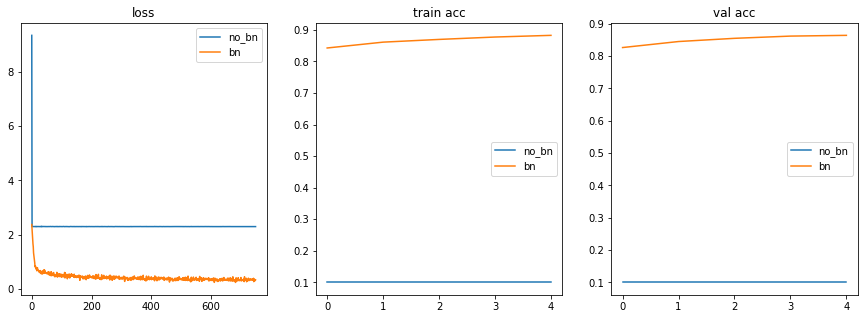

In [14]:
# Plot bn and no_bn results together in three plots and make a comparison. 
title_name = ["loss", "train acc", "val acc"]
_, axarr = plt.subplots(1,3, figsize=(15,5))
for i in range(3):
    axarr[i].plot(hist_deep_no_bn[i], label="no_bn")
    axarr[i].plot(hist_deep_bn[i], label="bn")
    axarr[i].legend(), axarr[i].set_title(title_name[i])
plt.show()

<span style="color:red"><strong>TODO:</strong></span> Describe what you find in this experiment.

**Answer:** <br/>
As for the shallow MLP, after adding the batch normalization, both the training accuracy and the validation accuracy increase, which means that batch normalization could fix the overfitting issue. And the loss value shows smaller fluctuations when we use batch normalization. 
As for the deeper MLP case, after adding the batch normalization, both validation and training accuracy sill increase. This means that for deeper networks the distribution of hidden layers is more prone to shift greatly and thus batch normalization could correct the shift better. 

## Part 2: Dropout

### Implement dropout_forward function

<span style="color:red"><strong>TODO:</strong></span> Edit function `dropout_forward` in `./utils/reg_funcs.py`. If the code is running correctly, you will see that the outputs of the verification code should be close to each other. 

If the function is correct, then **the output mean should be close to the input mean. Input mean and output test mean should be identical.**

During the forward stage of dropout, each entry in the original data are kept with a certain probability $p$, otherwise they are discarded (set to zero). Assume the input $X \in R^{N \times D}$, the forward pass is

$$Y = M \odot X \in R^{N \times D}$$

where $M \sim B(N \times D, p)$ is a boolean mask generated from Binomial distribution. 

In [18]:
x_in = np.random.randn(500, 500) + 10

In [19]:
################################################
# Checking/verification code. Don't change it. #
################################################
from utils.reg_funcs import dropout_forward
from utils.reg_funcs import dropout_backward

p = 0.7
dropout_config = {"enabled": True, "keep_prob": p}
# feedforward
out, cache = dropout_forward(x=x_in, dropout_config=dropout_config, mode="train")
out_test, _ = dropout_forward(x=x_in, dropout_config=dropout_config, mode="test") 
# backward
dout = np.ones_like(x_in)
dx = dropout_backward(dout, cache)
################################################
# Checking/verification code. Don't change it. #
################################################
# Check forward correctness
print("mean_of_input = {}".format(p*np.mean(x_in)))
print("mean_of_out = {}".format(np.mean(out)))
print("mean_of_out_test = {}".format(np.mean(out_test)))

mean_of_input = 7.0007819604041295
mean_of_out = 7.0068074214232965
mean_of_out_test = 7.0007819604041295


### Dropout Experiments with MLP

<span style="color:red"><strong>TODO:</strong></span>

1. Add dropout into the MLP in `./utils/neuralnets/mlp.py` and understand how the dropout is added into the MLP.

2. Customize your own MLP network. Then, train networks with different $p$ of $\{0.1, 0.3, 0.5, 0.7, 0.9, 1\}$. If $p = 1$, then the network is the MLP without dropout. 

3. Plot the loss, training accuracy, and validation accuracy curves.

Note that checking/validation code is included below with preselected dropout parameters.

In [20]:
# Here is an example on how to collect loss and accuracy info
dropout_config = {"enabled":True, "keep_prob": 1}
model = MLP(input_dim=X_train.shape[1], hidden_dims=[200], num_classes=10, 
            weight_scale=1e-3, l2_reg=0.0, dropout_config=dropout_config)
optimizer = AdamOptim(model)
# hist_no_dropout contains loss, train acc and valid acc history.
hist_no_dropout = optimizer.train(model, X_train, y_train, X_val, y_val, 
                           num_epoch=5, batch_size=100, learning_rate=1e-3, learning_decay=0.95, 
                           verbose=False, record_interval = 4)

number of batches for training: 600
epoch 1: valid acc = 0.8415, new learning rate = 0.00095
epoch 2: valid acc = 0.8586, new learning rate = 0.0009025
epoch 3: valid acc = 0.867, new learning rate = 0.000857375
epoch 4: valid acc = 0.8762, new learning rate = 0.0008145062499999999
epoch 5: valid acc = 0.8707, new learning rate = 0.0007737809374999998


In [21]:
dropout_config["keep_prob"] = 0.9
model = MLP(input_dim=X_train.shape[1], hidden_dims=[200], num_classes=10, 
            weight_scale=1e-2, l2_reg=0.0, dropout_config=dropout_config)
optimizer = AdamOptim(model)
hist_dropout_9 = optimizer.train(model, X_train, y_train, X_val, y_val, 
                           num_epoch=5, batch_size=100, learning_rate=1e-3, learning_decay=0.95,
                           verbose=False, record_interval = 4)

number of batches for training: 600
epoch 1: valid acc = 0.8451, new learning rate = 0.00095
epoch 2: valid acc = 0.8509, new learning rate = 0.0009025
epoch 3: valid acc = 0.8587, new learning rate = 0.000857375
epoch 4: valid acc = 0.8626, new learning rate = 0.0008145062499999999
epoch 5: valid acc = 0.8649, new learning rate = 0.0007737809374999998


In [22]:
dropout_config["keep_prob"] = 0.7
model = MLP(input_dim=X_train.shape[1], hidden_dims=[200], num_classes=10, 
            weight_scale=1e-2, l2_reg=0.0, dropout_config=dropout_config)
optimizer = AdamOptim(model)
hist_dropout_7 = optimizer.train(model, X_train, y_train, X_val, y_val, 
                           num_epoch=5, batch_size=100, learning_rate=1e-3, learning_decay=0.95,
                           verbose=False, record_interval = 4)

number of batches for training: 600
epoch 1: valid acc = 0.8365, new learning rate = 0.00095
epoch 2: valid acc = 0.8462, new learning rate = 0.0009025
epoch 3: valid acc = 0.8507, new learning rate = 0.000857375
epoch 4: valid acc = 0.8594, new learning rate = 0.0008145062499999999
epoch 5: valid acc = 0.8652, new learning rate = 0.0007737809374999998


In [23]:
dropout_config["keep_prob"] = 0.5
model = MLP(input_dim=X_train.shape[1], hidden_dims=[200], num_classes=10, 
            weight_scale=1e-2, l2_reg=0.0, dropout_config=dropout_config)
optimizer = AdamOptim(model)
hist_dropout_5 = optimizer.train(model, X_train, y_train, X_val, y_val, 
                           num_epoch=5, batch_size=100, learning_rate=1e-3, learning_decay=0.95,
                           verbose=False, record_interval = 4)

number of batches for training: 600
epoch 1: valid acc = 0.8304, new learning rate = 0.00095
epoch 2: valid acc = 0.8419, new learning rate = 0.0009025
epoch 3: valid acc = 0.8504, new learning rate = 0.000857375
epoch 4: valid acc = 0.8508, new learning rate = 0.0008145062499999999
epoch 5: valid acc = 0.8581, new learning rate = 0.0007737809374999998


In [24]:
dropout_config["keep_prob"] = 0.3
model = MLP(input_dim=X_train.shape[1], hidden_dims=[200], num_classes=10, 
            weight_scale=1e-2, l2_reg=0.0, dropout_config=dropout_config)
optimizer = AdamOptim(model)
hist_dropout_3 = optimizer.train(model, X_train, y_train, X_val, y_val, 
                           num_epoch=5, batch_size=100, learning_rate=1e-3, learning_decay=0.95,
                           verbose=False, record_interval = 4)

number of batches for training: 600
epoch 1: valid acc = 0.804, new learning rate = 0.00095
epoch 2: valid acc = 0.8218, new learning rate = 0.0009025
epoch 3: valid acc = 0.8229, new learning rate = 0.000857375
epoch 4: valid acc = 0.8291, new learning rate = 0.0008145062499999999
epoch 5: valid acc = 0.8276, new learning rate = 0.0007737809374999998


In [26]:
# small retention rate
dropout_config["keep_prob"] = 0.1
model = MLP(input_dim=X_train.shape[1], hidden_dims=[200], num_classes=10, 
            weight_scale=1e-2, l2_reg=0.0, dropout_config=dropout_config)
optimizer = AdamOptim(model)
hist_dropout_1 = optimizer.train(model, X_train, y_train, X_val, y_val, 
                           num_epoch=5, batch_size=100, learning_rate=1e-3, learning_decay=0.95,
                           verbose=False, record_interval = 4)

number of batches for training: 600
epoch 1: valid acc = 0.7164, new learning rate = 0.00095
epoch 2: valid acc = 0.735, new learning rate = 0.0009025
epoch 3: valid acc = 0.7491, new learning rate = 0.000857375
epoch 4: valid acc = 0.7549, new learning rate = 0.0008145062499999999
epoch 5: valid acc = 0.767, new learning rate = 0.0007737809374999998


In [27]:
loss_no_dropout, train_acc_no_dropout, val_acc_no_dropout = hist_no_dropout
loss_dropout_1, train_acc_dropout_1, val_acc_dropout_1 = hist_dropout_1
loss_dropout_3, train_acc_dropout_3, val_acc_dropout_3 = hist_dropout_3
loss_dropout_5, train_acc_dropout_5, val_acc_dropout_5 = hist_dropout_5
loss_dropout_7, train_acc_dropout_7, val_acc_dropout_7 = hist_dropout_7
loss_dropout_9, train_acc_dropout_9, val_acc_dropout_9 = hist_dropout_9

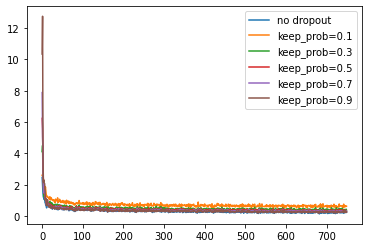

In [28]:
plt.plot(loss_no_dropout, label="no dropout")
plt.plot(loss_dropout_1, label="keep_prob=0.1")
plt.plot(loss_dropout_3, label="keep_prob=0.3")
plt.plot(loss_dropout_5, label="keep_prob=0.5")
plt.plot(loss_dropout_7, label="keep_prob=0.7")
plt.plot(loss_dropout_9, label="keep_prob=0.9")
plt.legend()
plt.show()

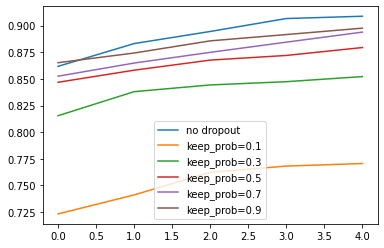

In [29]:
plt.plot(train_acc_no_dropout, label="no dropout")
plt.plot(train_acc_dropout_1, label="keep_prob=0.1")
plt.plot(train_acc_dropout_3, label="keep_prob=0.3")
plt.plot(train_acc_dropout_5, label="keep_prob=0.5")
plt.plot(train_acc_dropout_7, label="keep_prob=0.7")
plt.plot(train_acc_dropout_9, label="keep_prob=0.9")
plt.legend()
plt.show()

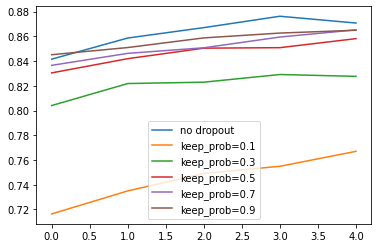

In [30]:
plt.plot(val_acc_no_dropout, label="no dropout")
plt.plot(val_acc_dropout_1, label="keep_prob=0.1")
plt.plot(val_acc_dropout_3, label="keep_prob=0.3")
plt.plot(val_acc_dropout_5, label="keep_prob=0.5")
plt.plot(val_acc_dropout_7, label="keep_prob=0.7")
plt.plot(val_acc_dropout_9, label="keep_prob=0.9")
plt.legend()
plt.show()

<span style="color:red"><strong>TODO:</strong></span> Describe what you find in this dropout experiment.

Answer: 
The aim to use dropout is to reduce the overfit.
And selecting a proper value of drop out is important to fix the overfitting problem. 

As for the training accuracy, it is wierd to find that no dropout shows the best validation and training accuracy. And as the keep ratio decrease, the validation and training accuracy value decrease. It may because the overfitting problem is not exist in this situation.

In summary, dropout is useful when it has overfitting problem, but we also need to check if there has a overfitting problem. If there are no overfitting, maybe we do not need to use dropout.

## Part 3: Dropout + Batch Normalization

In [31]:
# Create a deep network with both dropout and batch normalization.
dropout_config = {"enabled": True, "keep_prob": 0.6}
use_bn = True
model = MLP(input_dim=X_train.shape[1], hidden_dims=[100, 50], num_classes=10, 
            weight_scale=1e-3, l2_reg=0.0, dropout_config=dropout_config, use_bn=use_bn)
optimizer = AdamOptim(model)

# hist_no_dropout contains loss, train acc and valid acc history.
hist_deep_bn = optimizer.train(model, X_train, y_train, X_val, y_val, 
                           num_epoch=5, batch_size=200, learning_rate=2e-2, learning_decay=0.95, 
                           verbose=False, record_interval = 4)

number of batches for training: 300
epoch 1: valid acc = 0.7544, new learning rate = 0.019
epoch 2: valid acc = 0.7778, new learning rate = 0.01805
epoch 3: valid acc = 0.7861, new learning rate = 0.0171475
epoch 4: valid acc = 0.7913, new learning rate = 0.016290125
epoch 5: valid acc = 0.7953, new learning rate = 0.015475618749999998


## Reference
* Weight Normalization: A Simple Reparameterization to Accelerate Training of Deep Neural Networks https://arxiv.org/abs/1602.07868
* Highway netowrk https://arxiv.org/pdf/1505.00387.pdf